# ABOUT


Datascientest's Datascientist continuous bootcamp - cohorte Mars2022 -  AeroBOT project

**Tutor**

* Alban THUET

**Authors:**

* Hélène ASSIR
* [Ioannis STASINOPOULOS](https://www.linkedin.com/in/ioannis-stasinopoulos/)

</br>

---
</br>

**Version History**

Version | Date       | Author(s)  | Modification
--------|----------- | ---------  | --------------------------
1.0     | 30/07/2022 | I.S, H.A.  | Document creation

This notebook can be executed entirely. 

It

* mounts the GDrive of our AeroBot project @gmail account.

* loads the data from the `train_data_final.pkl` file (cf. `0_test_set_creator_DO_NOT_MODIFY_20220630.ipynb`) under a pandas DataFrame named `df`, which contains `97417` entries and 96 columns.
These data do not contain any more UAS-related entries.

* Loads the raw and pre-processed Narrative data once tokenized and stemmed ("Narrative_Raw_Stemmed_24072022_TRAIN.pkl" and "Narrative_PP_stemmed_24072022_TRAIN.pkl") (cf 03_Narr_Next preprocessing 20220721.ipynb)

* Provides an exploration of the vocabulary (#tokens, absolute and document frequencies) through tables and graphs


# IMPORT PACKAGES


settings for  full / patial Narrative display. Helene?


In [63]:
#######################
# Import packages
#######################
import numpy as np
import seaborn as sns
import math # for math.pi etc.
import time # time code execution

#######################
# Pandas
#######################
import pandas as pd
# Set pandas settings to show all data when using .head(), .columns etc.
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option("display.colheader_justify","left") # left-justify the print output of pandas

### Display full columnwidth
# Set pandas settings to display full text columns
#pd.options.display.max_colwidth = None
# Restore pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

import itertools # Pour créer des iterateurs

# Package to show the progression of pandas operations
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
# simply use .progress_apply() instead of .apply() on your pd.DataFram

######################
# PLOTTING
######################
import matplotlib.pyplot as plt
%matplotlib inline
# Define global plot parameters for better readability and consistency among plots
# A complete list of the rcParams keys can be retrieved via plt.rcParams.keys() function
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 23
plt.rcParams['xtick.labelsize'] = 23
plt.rcParams['ytick.labelsize'] = 23
plt.rc('legend', fontsize=23)    # legend fontsize

# BOKEH 
from bokeh.plotting import figure # Importation de la classe figure qui permet de créer un graphique bokeh.
from bokeh.io import  push_notebook, output_notebook, show
output_notebook() # permet d'afficher tous les futurs graphiques dans l'output d'une cellule jupyter. Si cette instruction n'est pas lancée, la figure s'affichera dans un nouvel onglet.
from bokeh.models import ColumnDataSource, Label
from bokeh.transform import dodge
from bokeh.models.tools import HoverTool

#####################
# NLP 
#####################
import re # for Regular Expression handling
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # WordNet lemmatizer
nltk.download('omw-1.4') # necessary for WordNet lemmatizer
from nltk.tokenize import word_tokenize # Usual tokenizer
from nltk.tokenize import TweetTokenizer # Special tokenizer;  "we'll", "didn't", etc. are considered as one word
from sklearn.feature_extraction.text import CountVectorizer # Vectorization
from nltk.corpus import stopwords # Import stopwords from nltk.corpus
from nltk.stem.snowball import EnglishStemmer

###############################
# ML preprocessing and models
###############################
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble # random forest
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix

###############################
# Deep Learning
###############################
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras import callbacks


###############################
# Other
###############################
import pickle as pkl # Saving data externally

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# LOAD DATA

## Mount GDrive

In [64]:
#@title
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive/')

#check your present working directory 
%pwd

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


'/content/drive/My Drive/data/transformed'

In [65]:
#@title
# move to the transformed data location (you can create a deeper structure, if needed, e.g. to save a trained model):
%cd /content/drive/MyDrive/data/transformed/

/content/drive/MyDrive/data/transformed


In [66]:
#@title
!ls # list the content of the pwd

#!ls "/content/drive/MyDrive/Data_Science/Formations/DataScienceTest/projet/AeroBot/" # list contect of a speficic folder

 2022_09_11_7_4_3_raw_narr_BERT_BASE_frozen_max_length_345.pkl
 complaints-2022-08-05_13_55.csv
'Copy of Qualified abbreviations_20220718.xlsx.gsheet'
'Data Dictionnary.xlsx'
 data_for_BERT_multilabel_20220805.pkl
 df_for_Anomaly_prediction.pkl
 df_test_for_Anomaly_prediction.pkl
 model.png
 model_results
 Narrative_PP_stemmed_24072022_TRAIN.pkl
 Narrative_Raw_Stemmed_24072022_TRAIN.pkl
 Narrative_RegEx_subst_21072022_TRAIN.pkl
'Qualified abbreviations_20220707_test.csv'
'Qualified abbreviations_20220708.csv'
'Qualified abbreviations_20220718.csv'
'Qualified abbreviations_20220718_Google_sheet.gsheet'
 test_data_final.pkl
 train_data_final.pkl


## Load data from .pkl file


In [67]:
#@title
# Load the TRAIN data (97417 entries)
# Do not touch the TEST data until the end of the project!
# or the curse of the greek gods will fall upon you!

%cd /content/drive/MyDrive/data/transformed/
with open("train_data_final.pkl", "rb") as f:
    loaded_data = pkl.load(f)

df = loaded_data[0]
print("\nA Dataframe with", len(df), "entries has been loaded")

/content/drive/MyDrive/data/transformed

A Dataframe with 97417 entries has been loaded


# NARRATIVES : VOCABULARY METRICS

### Load the pre-processed Narrative data 

See the notebook that performs the substitutions

In [68]:
# Load the file Narrative_PP_stemmed_21072022_TRAIN.pkl
%cd /content/drive/MyDrive/data/transformed/
with open("Narrative_PP_stemmed_24072022_TRAIN.pkl", "rb") as f:
    loaded_narr = pkl.load(f)

df['Narrative_PP_stemmed'] = loaded_narr[0]
print("Data loaded")

/content/drive/MyDrive/data/transformed
Data loaded


In [69]:
# Load the file Narrative_PP_stemmed_21072022_TRAIN.pkl
%cd /content/drive/MyDrive/data/transformed/
with open("Narrative_Raw_Stemmed_24072022_TRAIN.pkl", "rb") as f:
    loaded_narr = pkl.load(f)

df['Narrative_Raw_Stemmed'] = loaded_narr[0]
print("Data loaded")

/content/drive/MyDrive/data/transformed
Data loaded


In [70]:
df.loc[1715282]['Narrative']

"I am writing this report to bring attention to the second departure frequency out of MDW last night. It is a safety issue to give us two frequency changes below 3;000 feet on departure out of MDW.We were in a heavy [aircraft] doing a full power; flaps 25; bleeds off takeoff off of 22L. These takeoffs are known to have very high climb rates; so the intermediate level-off of 3;000 feet approaches fast. At 1;000 feet; we're instructed to contact Departure on 128.2. Simultaneously; I switch frequencies and retract flaps as commanded by the pilot flying. Upon checking in with 128.2; he instructs us to climb and maintain 4;000 feet and subsequently contact 126.62. I dial in 4;000 feet and continue to retract flaps while monitoring a level-off from a climb rate of over 2;000 FPM. At this point; my head turns down to the radio to dial the new Departure frequency in. I check in and they tell us to climb and maintain 12;000 feet. I dial in 12;000 feet; confirm it; reset the autobrake and gear l

In [71]:
df.loc[1715282]['Narrative_PP_stemmed'][:20]

['write',
 'report',
 'bring',
 'attent',
 'second',
 'departur',
 'frequenc',
 'mdw',
 'last',
 'night',
 'safeti',
 'issu',
 'give',
 'us',
 'two',
 'frequenc',
 'chang',
 '3',
 '000',
 'feet']

In [72]:
df.loc[1715282]['Narrative_Raw_Stemmed'][:20]

['write',
 'report',
 'bring',
 'attent',
 'second',
 'departur',
 'frequenc',
 'mdw',
 'last',
 'night',
 'safeti',
 'issu',
 'give',
 'us',
 'two',
 'frequenc',
 'chang',
 '3',
 '000',
 'feet']

## Metrics on vocabulary

size (#words), absolute frequencies, document frequencies...

- See the impact of our Narrative preprocessing
- New contractions may appear : To be added to our Contractions list with full-text replacement

### Length RAW vs. stemmed

In [73]:
# Calculate the length
df['Narrative_PP_stemmed_len'] = df['Narrative_PP_stemmed'].apply(lambda x: len(x))
df['Narrative_Raw_stemmed_len'] = df['Narrative_Raw_Stemmed'].apply(lambda x: len(x))

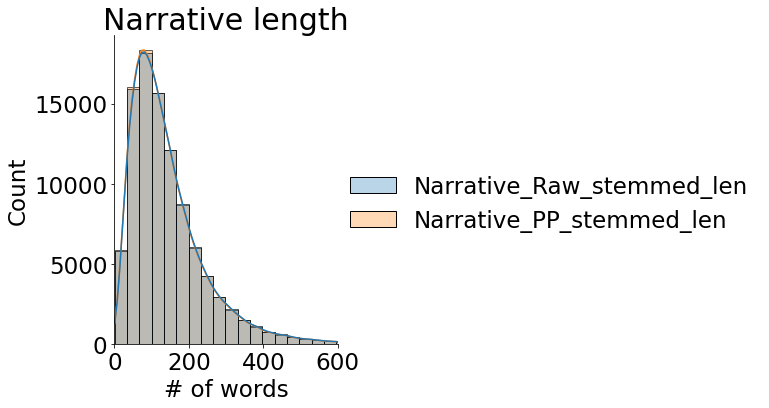

In [74]:
# Plot histograms
sns.displot([df['Narrative_Raw_stemmed_len'], df['Narrative_PP_stemmed_len']],
            bins = 40, kde = True, alpha  = 0.3)
plt.xlim([0,600])
plt.xlabel('# of words')
plt.title('Narrative length');

### Raw data, stemmed

In [75]:
# Join all tokens into a single string
df['Narrative_Raw_Stemmed_str'] = df['Narrative_Raw_Stemmed'].apply(lambda token_list: ' '.join(entry for entry in token_list))

# Instantiate the vectorizer with default settings
vectorizer = CountVectorizer() 

# Sparse matrix
spm = vectorizer.fit_transform(df['Narrative_Raw_Stemmed_str']) # scipy.sparse.csr_matrix object
# Compressed Sparse Row matrix

# Instantiate a second CountVectorizer with the the binary = True option 
vectorizer_bool = CountVectorizer(binary = True) # all non zero counts are set to 1

# Sparse matrix in boolean form
spm_bool = vectorizer_bool.fit_transform(df['Narrative_Raw_Stemmed_str'])

In [76]:
# Vocabulary
vocab = vectorizer.get_feature_names_out()
# ordered by the word indices
print(f"Vocabulary length: {len(vocab)}")

Vocabulary length: 57732


#### Function definitions

The sparse matrix is a very memory-greedy object and causes RAM crash when we wish to cast it to an array and visualize it.

Therefore, to obtain the word occurences, we use built-in methods of the sparse matrix.

In [77]:
def get_word_occurence(spm, vectorizer):
  """
  Inputs: 
  - sparse matrix as scipy.sparse.csr_matrix object
  If the sparse matrix is in boolean form, you will get the DOCUMENT frequency
  - vectorizer object

  Return a df with:
  column 'token' = vocab word
  column 'word_idx' = vocabulary index of the word
  column 'occurence' = word occurence (absolute or document frequency, depending on inputs passed)
  """

  # Get the vocabulary directly from the vectorizer object
  vocab = vectorizer.get_feature_names_out()

  # Calculate the occurence:
  # perform the sum on the sparse matrix and transform it to an array:
  occurence = np.asarray(spm.sum(axis=0)).ravel()

  # Write data into a DataFrame
  # The df.index are the words
  word_occ_df = pd.DataFrame(occurence, index = vocab, columns = ['occurence'])

  # Copy the df.index (i.e. the words) into a new column
  word_occ_df['word_idx'] = word_occ_df.index
  # Get the vocab index of each word into a new column
  word_occ_df['word_idx'] = word_occ_df['word_idx'].apply(lambda x: vectorizer.vocabulary_[x])

  # Reorder columns
  word_occ_df = word_occ_df[['word_idx', 'occurence']]

  # Reset index
  word_occ_df = word_occ_df.reset_index().rename(columns = {'index': 'token'})
  word_occ_df

  return word_occ_df

In [78]:
def get_abs_doc_frequ(spm, spm_bool, vectorizer, vectorizer_bool):
  """
  Calculate absolute frequency and document frequency
  Input: sparse matrix and vectorizer object in 'normal' and boolean form, i.e.
  using the option 'CountVectorizer(binary = True)'

  Return a DataFrame with token, token_id, absolute and document frequency
  """

  # Create absolute and document frequency DataFrames
  word_ABS_frequ = get_word_occurence(spm, vectorizer)
  word_DOC_frequ = get_word_occurence(spm_bool, vectorizer_bool)

  # Merge dataframes on 'token'
  word_frequencies = word_ABS_frequ.merge(word_DOC_frequ, on = 'token', how = 'left')

  # Check that the two DataFrames have identical length and that two columns are identical
  if (len(word_ABS_frequ) == len(word_DOC_frequ)) & (sum(word_frequencies['word_idx_x'] != word_frequencies['word_idx_y']) == 0):
    print("Merge successful on column 'token'\n")

  else:
    print('There is an inconsistency among the two word indices!')

  # Drop unnecessary columns and rename columns
  word_frequencies = word_frequencies.drop(columns = ['word_idx_y'])
  word_frequencies = word_frequencies.rename(columns = {'word_idx_x': 'token_id', 'occurence_x': 'abs_frequ', 'occurence_y': 'doc_frequ'})

  return word_frequencies

In [79]:
frequencies = get_abs_doc_frequ(spm, spm_bool, vectorizer, vectorizer_bool)
frequencies = frequencies.sort_values(by = 'abs_frequ', ascending = False)
frequencies.head(10)

Merge successful on column 'token'



,token,token_id,abs_frequ,doc_frequ
13281,aircraft,13281,150225,36482
53250,us,53250,93352,36751
50908,time,50908,85024,44092
12725,acft,12725,84546,26389
27208,ft,27208,83141,28245
45880,rwi,45880,79515,19209
34088,land,34088,79010,36408
51906,turn,51906,78599,34384
55608,would,55608,78259,39295
26478,flight,26478,78173,28860


#### Plot

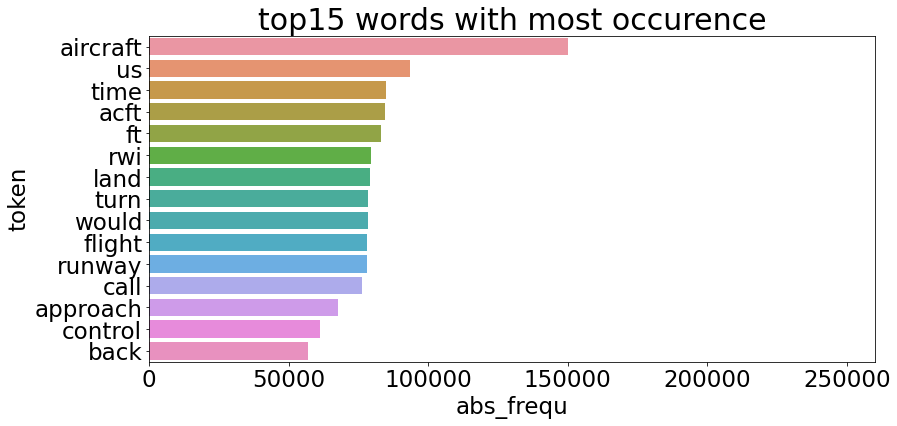

In [80]:
data = frequencies.sort_values(by = 'abs_frequ', ascending = False)
# Plot the top X occurences
topX = 15

fig = plt.figure(figsize = (13,6))
plt.ylim(topX - 0.5)
plt.xlim([0, 260000])
plt.xlabel('Count')
plt.title(f"top{topX} words with most occurence")
sns.barplot(data = data[:topX], y = data['token'][:topX], x = 'abs_frequ');

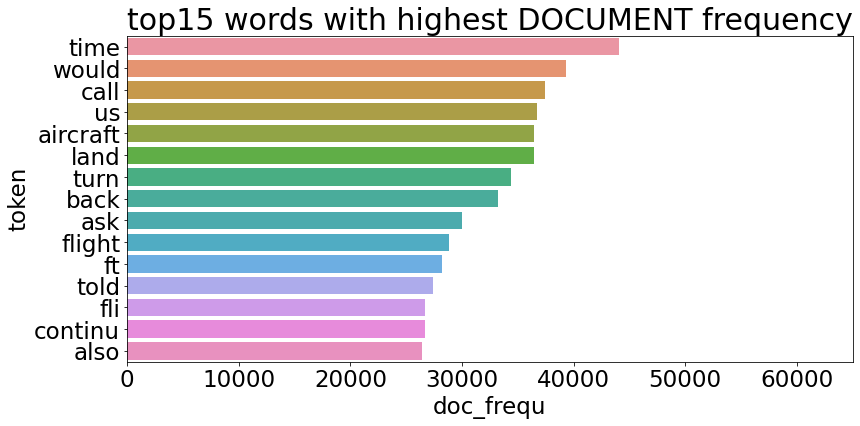

In [81]:
# Plot the top X DOCUMENT frequency occurences
# Sort by highest DOCUMENT frequency
data = frequencies.sort_values(by = 'doc_frequ', ascending = False)

topX = 15

fig = plt.figure(figsize = (13,6))
plt.ylim(topX - 0.5)
plt.xlim([0, 65000])
plt.xlabel('Count')
plt.title(f"top{topX} words with highest DOCUMENT frequency")
sns.barplot(data = data[:topX], y = data['token'][:topX], x = 'doc_frequ');

### Preprocessed narratives (default CountVectorizer settings)

In [82]:
# Join all tokens into a single string
df['Narrative_PP_stemmed_str'] = df['Narrative_PP_stemmed'].apply(lambda token_list: ' '.join(entry for entry in token_list))

In [83]:
# Instantiate the vectorizer
vectorizer = CountVectorizer() 

# Sparse matrix
spm = vectorizer.fit_transform(df['Narrative_PP_stemmed_str']) # scipy.sparse.csr_matrix object
# Compressed Sparse Row matrix

# Vocabulary
vocab = vectorizer.get_feature_names_out()
# ordered by the word indices
print(f"Vocabulary length: {len(vectorizer.get_feature_names_out())}")

# Instantiate a second CountVectorizer with the the binary = True option 
vectorizer_bool = CountVectorizer(binary = True) # all non zero counts are set to 1

# Sparse matrix in boolean form
spm_bool = vectorizer_bool.fit_transform(df['Narrative_PP_stemmed_str'])

Vocabulary length: 55878


In [84]:
frequencies = get_abs_doc_frequ(spm, spm_bool, vectorizer, vectorizer_bool)
frequencies = frequencies.sort_values(by = 'abs_frequ', ascending = False)
frequencies.head(10)

Merge successful on column 'token'



,token,token_id,abs_frequ,doc_frequ
12045,aircraft,12045,233877,62623
44075,runway,44075,214363,43922
24348,feet,24348,141647,44452
24822,flight,24822,113393,45512
32414,land,32414,105066,44433
13004,approach,13004,103289,35710
18885,control,18885,93891,37540
51506,us,51506,93336,36745
49167,time,49167,85020,44092
50163,turn,50163,78599,34384


#### Plot

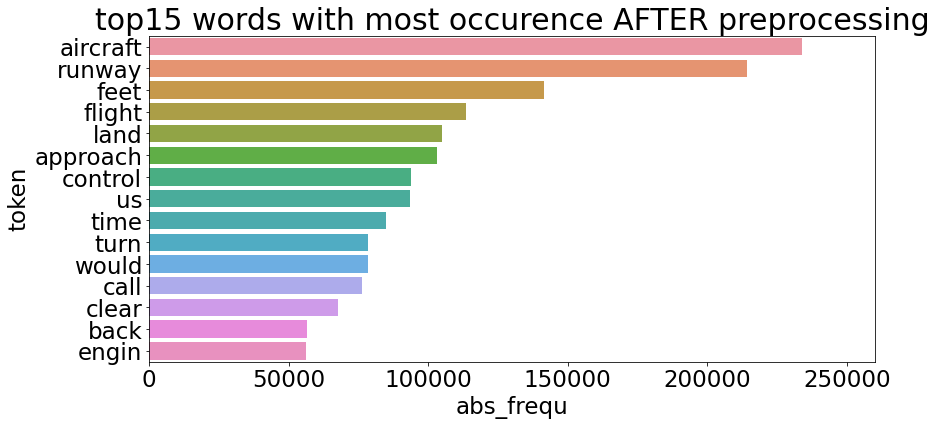

In [85]:
data = frequencies.sort_values(by = 'abs_frequ', ascending = False)
# Plot the top X occurences
topX = 15

fig = plt.figure(figsize = (13,6))
plt.ylim(topX - 0.5)
plt.xlim([0, 260000])
plt.xlabel('Count')
plt.title(f"top{topX} words with most occurence AFTER preprocessing")
sns.barplot(data = data[:topX], y = data['token'][:topX], x = 'abs_frequ');

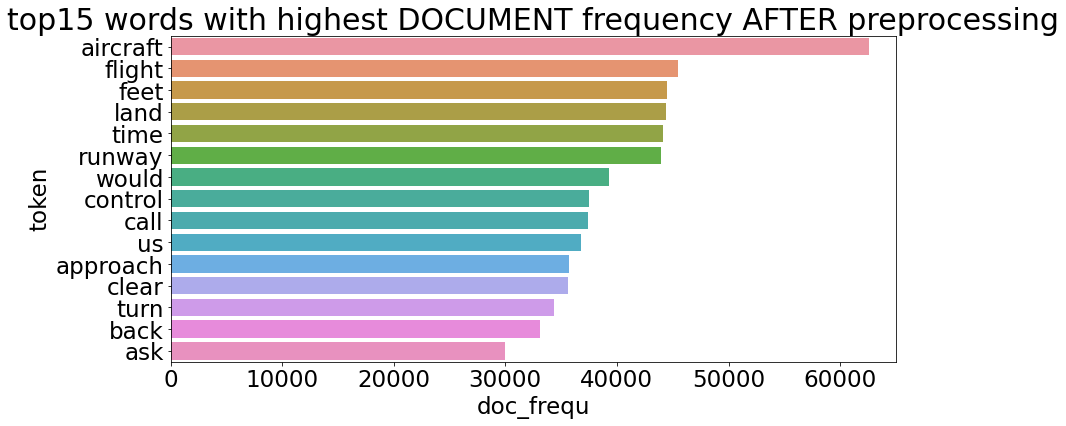

In [86]:
# Plot the top X DOCUMENT frequency occurences
# Sort by highest DOCUMENT frequency
data = frequencies.sort_values(by = 'doc_frequ', ascending = False)

topX = 15

fig = plt.figure(figsize = (13,6))
plt.ylim(topX - 0.5)
plt.xlim([0, 65000])
plt.xlabel('Count')
plt.title(f"top{topX} words with highest DOCUMENT frequency AFTER preprocessing")
sns.barplot(data = data[:topX], y = data['token'][:topX], x = 'doc_frequ');

### Preprocessed narratives (no numbers - RegEx setting)

In [87]:
# Join all tokens into a single string
df['Narrative_PP_stemmed_str'] = df['Narrative_PP_stemmed'].apply(lambda token_list: ' '.join(entry for entry in token_list))

# Instantiate the vectorizer that IGNORES NUMBERS and UNDERSCORES
vectorizer = CountVectorizer(token_pattern=r"\b[a-zA-Z][a-zA-Z]+\b") 
# the default RegEx is: "\b\w\w+\b"
# reminder: \w = [a-zA-Z0-9_]
# That means it finds anything of length 2 or longer that has word boundaries, 
# which are any punctuation or white spaces, and matches \w. 
# This includes any numbers. Numbers can be at the beginning of the word, 
# the middle of the word or it can be just all numbers.

# Sparse matrix
spm = vectorizer.fit_transform(df['Narrative_PP_stemmed_str']) # scipy.sparse.csr_matrix object
# Compressed Sparse Row matrix

# Vocabulary
vocab = vectorizer.get_feature_names_out()
# ordered by the word indices
print(f"Vocabulary length: {len(vectorizer.get_feature_names_out())}")

# Instantiate a second CountVectorizer with the the binary = True option 
vectorizer_bool = CountVectorizer(token_pattern=r"\b[a-zA-Z][a-zA-Z]+\b",
                                  binary = True) # all non zero counts are set to 1

# Sparse matrix in boolean form
spm_bool = vectorizer_bool.fit_transform(df['Narrative_PP_stemmed_str'])

Vocabulary length: 40034


In [88]:
frequencies = get_abs_doc_frequ(spm, spm_bool, vectorizer, vectorizer_bool)
frequencies = frequencies.sort_values(by = 'abs_frequ', ascending = False)
frequencies.head(10)

Merge successful on column 'token'



,token,token_id,abs_frequ,doc_frequ
832,aircraft,832,233877,62623
30051,runway,30051,214363,43922
12131,feet,12131,141647,44452
12590,flight,12590,113393,45512
19452,land,19452,105066,44433
1757,approach,1757,103289,35710
7075,control,7075,93891,37540
37044,us,37044,93336,36745
34842,time,34842,85020,44092
35807,turn,35807,78599,34384


In [89]:
frequencies[frequencies['token'] == '0200']

,token,token_id,abs_frequ,doc_frequ


In [90]:
frequencies.describe()

,token_id,abs_frequ,doc_frequ
count,40034.000000,40034.000000,40034.000000
mean,20016.500000,326.915946,205.443598
std,11556.964675,3099.379692,1486.614641
min,0.000000,1.000000,1.000000
25%,10008.250000,1.000000,1.000000
50%,20016.500000,3.000000,2.000000
75%,30024.750000,17.000000,11.000000
max,40033.000000,233877.000000,62623.000000


#### Plot

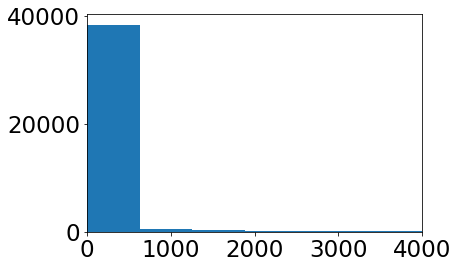

In [91]:
plt.hist(frequencies['doc_frequ'], bins = 100)
plt.xlim(0,4000);

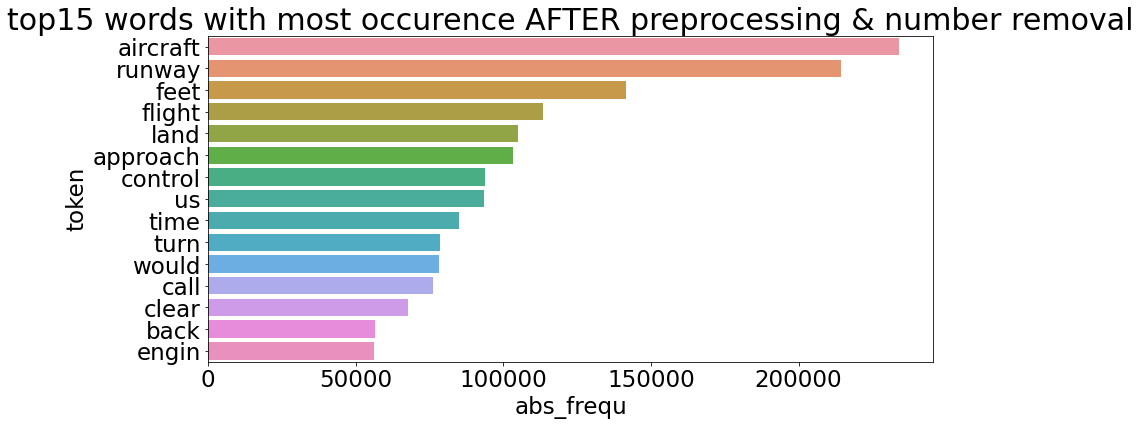

In [92]:
data = frequencies.sort_values(by = 'abs_frequ', ascending = False)
# Plot the top X occurences
topX = 15

fig = plt.figure(figsize = (13,6))
plt.ylim(topX - 0.5)
plt.xlabel('Count')
plt.title(f"top{topX} words with most occurence AFTER preprocessing & number removal")
sns.barplot(data = data[:topX], y = data['token'][:topX], x = 'abs_frequ');

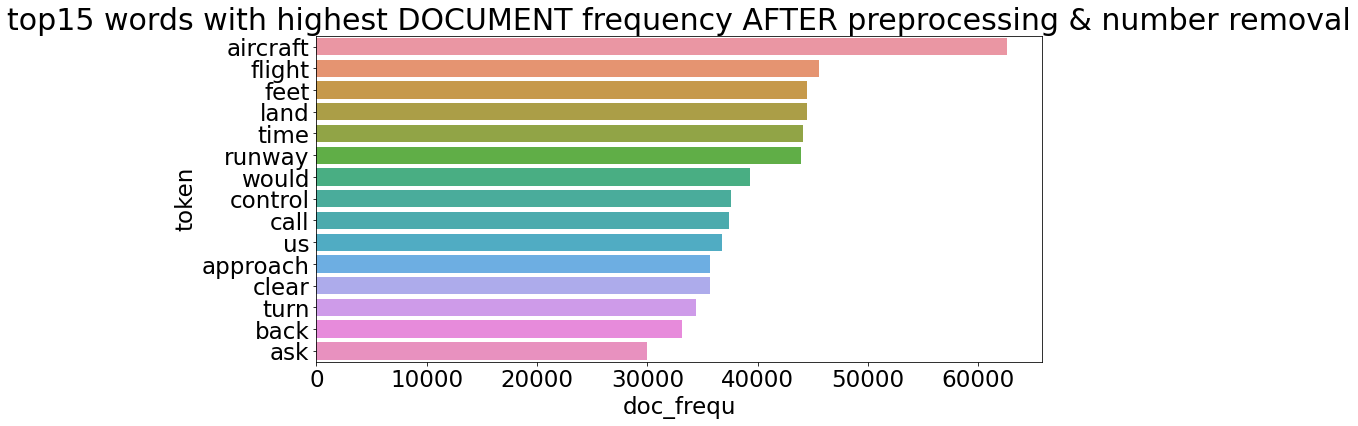

In [93]:
# Plot the top X DOCUMENT frequency occurences
# Sort by highest DOCUMENT frequency
data = frequencies.sort_values(by = 'doc_frequ', ascending = False)

topX = 15

fig = plt.figure(figsize = (13,6))
plt.ylim(topX - 0.5)
plt.xlabel('Count')
plt.title(f"top{topX} words with highest DOCUMENT frequency AFTER preprocessing & number removal")
sns.barplot(data = data[:topX], y = data['token'][:topX], x = 'doc_frequ');

In [94]:
pts_to_annotate = frequencies[frequencies['abs_frequ'] > 50000]
for idx in pts_to_annotate.index:
  print(pts_to_annotate.loc[idx]['token'])

aircraft
runway
feet
flight
land
approach
control
us
time
turn
would
call
clear
back
engin
tower
altitud
mainten
atc
ask
pilot
airport
told


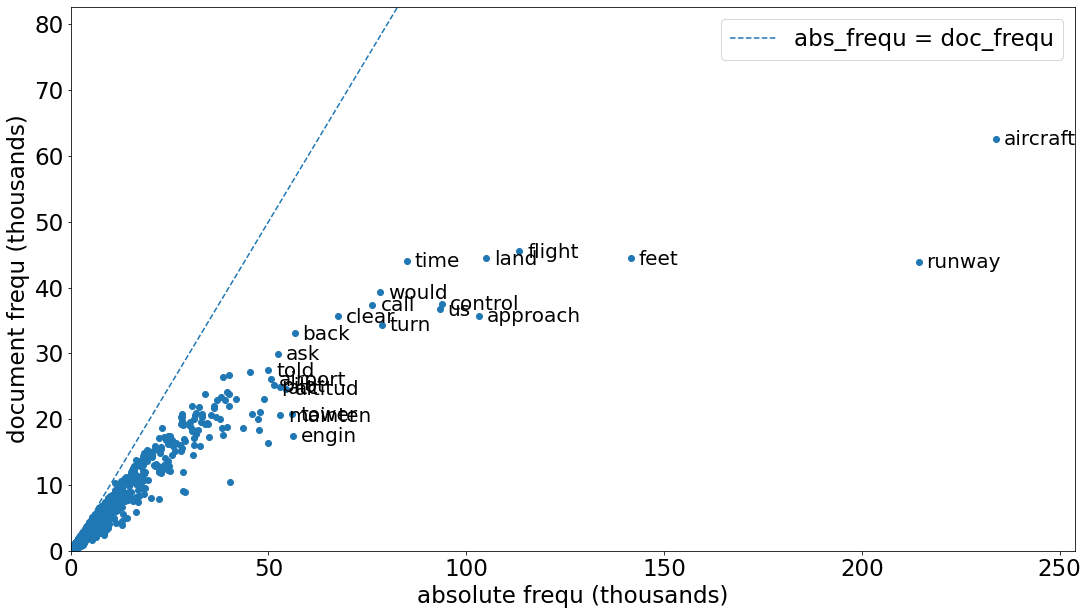

In [95]:
fig = plt.figure(figsize = (18,10))
plt.scatter(frequencies['abs_frequ']/1000, frequencies['doc_frequ']/1000)
plt.xlabel('absolute frequ (thousands)')
plt.ylabel('document frequ (thousands)')
plt.plot([0,150], [0, 150], '--', label = 'abs_frequ = doc_frequ')
plt.xlim([0, frequencies['abs_frequ'].max()/1000 + 20])
plt.ylim([0, frequencies['doc_frequ'].max()/1000 + 20])

# Annotate words with high absolute frequency
pts_to_annotate = frequencies[frequencies['abs_frequ'] > 50000]
for idx in pts_to_annotate.index:
  row = pts_to_annotate.loc[idx]
  plt.annotate(row['token'], xy = (row['abs_frequ']/1000 +2, row['doc_frequ']/1000 - 1), size=20)

plt.legend();

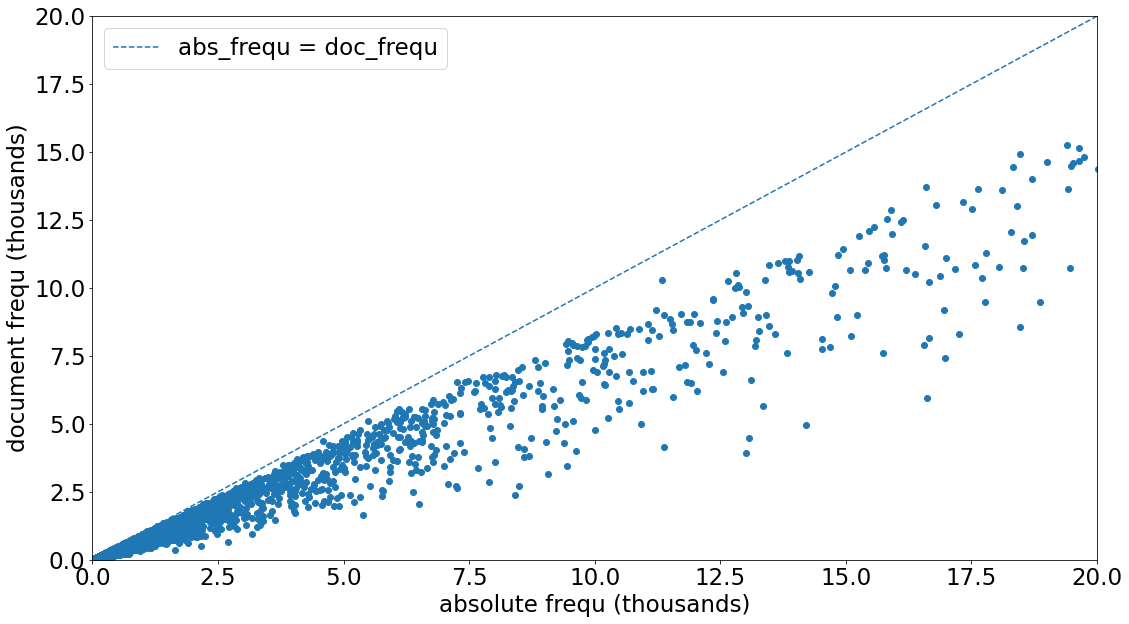

In [96]:
# ZOOM 
fig = plt.figure(figsize = (18,10))
plt.scatter(frequencies['abs_frequ']/1000, frequencies['doc_frequ']/1000)
plt.xlabel('absolute frequ (thousands)')
plt.ylabel('document frequ (thousands)')
plt.plot([0,150], [0, 150], '--', label = 'abs_frequ = doc_frequ')

# Restrict plot area
plt.xlim([0, 20])
plt.ylim([0, 20])

# # Annotate words with high absolute frequency
# pts_to_annotate = frequencies[frequencies['abs_frequ'] > 50000]
# for idx in pts_to_annotate.index:
#   row = pts_to_annotate.loc[idx]
#   plt.annotate(row['token'], xy = (row['abs_frequ']/1000 +2, row['doc_frequ']/1000 - 1), size=20)

plt.legend();